In [56]:
import pickle
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

# Point this to your local run
PROJECT_ROOT = Path("/Users/edwardphillips/Documents/Oxford/Projects/conformal-probes")
RUNS_ROOT = PROJECT_ROOT / "runs_local"

# e.g. your test run
# run_dir = RUNS_ROOT / "Qwen3-1.7B__trivia_qa"
run_dir = RUNS_ROOT / "Qwen3-1.7B__trivia_qa" / "edwardphillips/uncertainty/wandb/offline-run-20251128_162329-oye2m2ob/files/"

val_path = run_dir / "validation_generations.pkl"
unc_path = run_dir / "uncertainty_measures.pkl"
probes_path = run_dir / "probes.pkl"

val_path, unc_path, probes_path


(PosixPath('/Users/edwardphillips/Documents/Oxford/Projects/conformal-probes/runs_local/Qwen3-1.7B__trivia_qa/edwardphillips/uncertainty/wandb/offline-run-20251128_162329-oye2m2ob/files/validation_generations.pkl'),
 PosixPath('/Users/edwardphillips/Documents/Oxford/Projects/conformal-probes/runs_local/Qwen3-1.7B__trivia_qa/edwardphillips/uncertainty/wandb/offline-run-20251128_162329-oye2m2ob/files/uncertainty_measures.pkl'),
 PosixPath('/Users/edwardphillips/Documents/Oxford/Projects/conformal-probes/runs_local/Qwen3-1.7B__trivia_qa/edwardphillips/uncertainty/wandb/offline-run-20251128_162329-oye2m2ob/files/probes.pkl'))

In [57]:
with val_path.open("rb") as f:
    val_gens = pickle.load(f)

len(val_gens), list(val_gens.keys())[:5]


(100,
 ['bb_1742--180/180_871091.txt#0_0',
  'qb_404--89/89_2634070.txt#0_0',
  'bb_7851--165/165_1006156.txt#0_0',
  'odql_4564--45/45_1774711.txt#0_0',
  'qb_4246--21/21_114528.txt#0_0'])

In [58]:
# Grab one arbitrary example
first_key = list(val_gens.keys())[0]
ex = val_gens[first_key]

ex.keys()


dict_keys(['question', 'context', 'most_likely_answer', 'reference', 'responses'])

In [59]:
print("Question:", ex.get("question"))
print("Context:", ex.get("context")[:200] if ex.get("context") else None)

print("\nNum generations:", len(ex["responses"]))
print("First response text:", ex["responses"][0][0])
print("First response token LLs length:", len(ex["responses"][0][1]))

most = ex["most_likely_answer"]
print("\nMost likely answer:", most["response"])
print("Accuracy label:", most["accuracy"])

emb_last_before_gen = most["emb_last_tok_before_gen"]
emb_before_eos = most["emb_tok_before_eos"]

print("TBG embedding shape:", emb_last_before_gen.shape)
print("SLT embedding shape:", emb_before_eos.shape)


Question: The International Bureau of Weights and Measures is based in which European country?
Context: [DOC] [TLE] International Bureau of Weights and MeasuresThe International Bureau of Weights and Measures (), is an international standards organisation, one of three such organisations established to 

Num generations: 10
First response text: The International Bureau of Weights and Measures is based in France.
First response token LLs length: 13

Most likely answer: The International Bureau of Weights and Measures is based in France.
Accuracy label: 1.0
TBG embedding shape: torch.Size([29, 1, 2048])
SLT embedding shape: torch.Size([29, 1, 2048])


In [60]:
with unc_path.open("rb") as f:
    unc = pickle.load(f)

unc.keys()


dict_keys(['uncertainty_measures', 'validation_is_false'])

In [61]:
measures = unc["uncertainty_measures"]
validation_is_false = np.array(unc["validation_is_false"])

list(measures.keys()), validation_is_false.shape


(['cluster_assignment_entropy',
  'semantic_entropy_sum',
  'semantic_entropy_sum-normalized',
  'semantic_entropy_sum-normalized-rao',
  'semantic_entropy_mean'],
 (100,))

In [62]:
cluster_ent = np.array(measures["cluster_assignment_entropy"])

print("Num points:", len(cluster_ent))
print("Mean cluster entropy:", cluster_ent.mean())
print("Fraction incorrect (validation_is_false):", validation_is_false.mean())

# Rough AUROC: does higher SE correlate with error?
auc = roc_auc_score(validation_is_false, cluster_ent)
print("AUROC(cluster_entropy vs is_false):", auc)


Num points: 100
Mean cluster entropy: 1.3941572089363974
Fraction incorrect (validation_is_false): 0.58
AUROC(cluster_entropy vs is_false): 0.7577996715927751


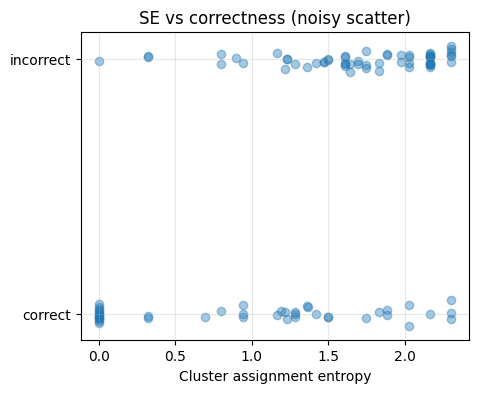

In [63]:
plt.figure(figsize=(5,4))
plt.scatter(cluster_ent, validation_is_false + np.random.normal(0, 0.02, size=len(validation_is_false)), alpha=0.4)
plt.yticks([0, 1], ["correct", "incorrect"])
plt.xlabel("Cluster assignment entropy")
plt.title("SE vs correctness (noisy scatter)")
plt.grid(True, alpha=0.3)
plt.show()


In [69]:
with val_path.open("rb") as f:
    generations = pickle.load(f)

with unc_path.open("rb") as f:
    measures = pickle.load(f)

entropy = np.array(measures["uncertainty_measures"]["cluster_assignment_entropy"])
acc = np.array([rec["most_likely_answer"]["accuracy"] for rec in generations.values()])

# following SEP convention: 1 = incorrect
is_false = 1.0 - acc

entropy.shape, acc.mean()


((100,), np.float64(0.42))

In [70]:
entropy_auc = roc_auc_score(is_false, entropy)
entropy_auc


0.7577996715927751

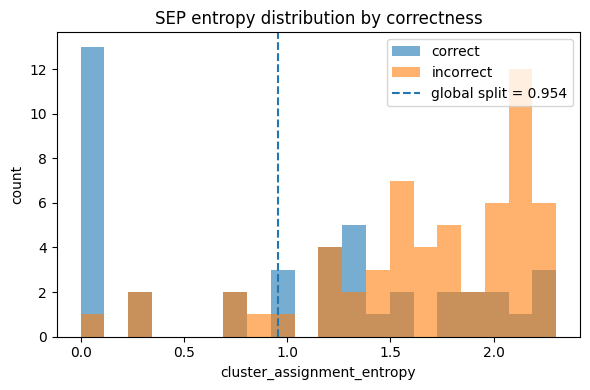

In [71]:
plt.figure(figsize=(6,4))
plt.hist(entropy[acc == 1.0], bins=20, alpha=0.6, label="correct")
plt.hist(entropy[acc == 0.0], bins=20, alpha=0.6, label="incorrect")
plt.axvline(split, linestyle="--", label=f"global split = {split:.3f}")
plt.xlabel("cluster_assignment_entropy")
plt.ylabel("count")
plt.title("SEP entropy distribution by correctness")
plt.legend()
plt.tight_layout()
plt.show()


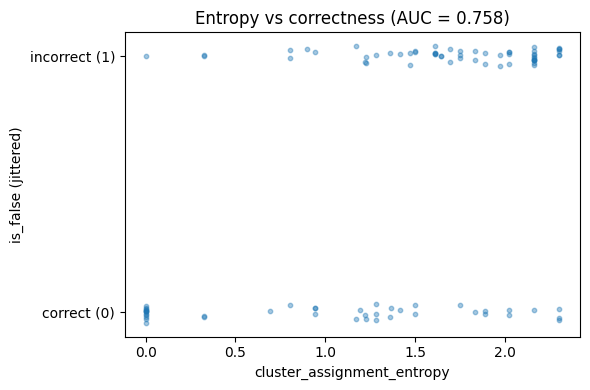

In [72]:
y = is_false + 0.02*np.random.randn(len(is_false))  # jitter for visibility

plt.figure(figsize=(6,4))
plt.scatter(entropy, y, s=10, alpha=0.4)
plt.yticks([0,1], ["correct (0)", "incorrect (1)"])
plt.xlabel("cluster_assignment_entropy")
plt.ylabel("is_false (jittered)")
plt.title(f"Entropy vs correctness (AUC = {entropy_auc:.3f})")
plt.tight_layout()
plt.show()


In [64]:
with probes_path.open("rb") as f:
    Ds_save = pickle.load(f)

type(Ds_save), len(Ds_save)


(dict, 2)

In [65]:
Ds_save

{'split': 0.9535958766937256,
 'results': {'Qwen3-1.7B__trivia_qa': {'tb_aucs': [0.14285714285714285,
    0.4761904761904762,
    0.5238095238095238,
    0.5714285714285714,
    0.5714285714285714,
    0.5238095238095238,
    0.38095238095238093,
    0.5238095238095238,
    0.2857142857142857,
    0.4285714285714286,
    0.33333333333333337,
    0.33333333333333337,
    0.5714285714285714,
    0.42857142857142855,
    0.42857142857142855,
    0.5238095238095238,
    0.6190476190476191,
    0.7142857142857143,
    0.5714285714285714,
    0.5238095238095238,
    0.6190476190476191,
    0.380952380952381,
    0.1904761904761905,
    0.28571428571428575,
    0.28571428571428575,
    0.5714285714285715,
    0.2380952380952381,
    0.2380952380952381,
    0.4761904761904762],
   'sb_aucs': [0.5,
    0.7619047619047619,
    0.6190476190476191,
    0.8095238095238095,
    0.9047619047619048,
    0.9523809523809524,
    0.9047619047619049,
    0.8095238095238095,
    0.7619047619047619,
    0.7

In [66]:
split = Ds_save["split"]
results = Ds_save["results"]

list(results.keys())


['Qwen3-1.7B__trivia_qa']

In [67]:
run_key = list(results.keys())[0]
R = results[run_key]

R.keys()


dict_keys(['tb_aucs', 'sb_aucs', 'ta_aucs', 'sa_aucs', 'tb_models', 'sb_models', 'ta_models', 'sa_models'])

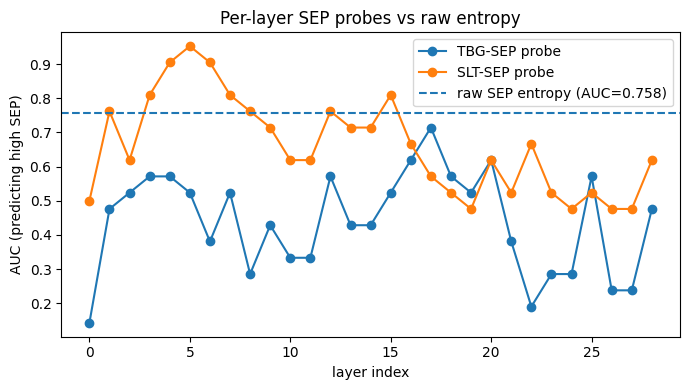

In [73]:
tb_aucs = np.array(R["tb_aucs"])
sb_aucs = np.array(R["sb_aucs"])
ta_aucs = np.array(R["ta_aucs"])
sa_aucs = np.array(R["sa_aucs"])

layers = np.arange(len(tb_aucs))

plt.figure(figsize=(7,4))
plt.plot(layers, tb_aucs, marker="o", label="TBG-SEP probe")
plt.plot(layers, sb_aucs, marker="o", label="SLT-SEP probe")
plt.axhline(entropy_auc, linestyle="--", label=f"raw SEP entropy (AUC={entropy_auc:.3f})")
plt.xlabel("layer index")
plt.ylabel("AUC (predicting high SEP)")
plt.title("Per-layer SEP probes vs raw entropy")
plt.legend()
plt.tight_layout()
plt.show()


In [74]:
best_tbg_layer = int(np.nanargmax(tb_aucs))
best_slt_layer = int(np.nanargmax(sb_aucs))
best_tbg_auc = tb_aucs[best_tbg_layer]
best_slt_auc = sb_aucs[best_slt_layer]

print(f"Raw entropy AUC:        {entropy_auc:.3f}")
print(f"Best TBG SEP layer {best_tbg_layer}: AUC = {best_tbg_auc:.3f}")
print(f"Best SLT SEP layer {best_slt_layer}: AUC = {best_slt_auc:.3f}")


Raw entropy AUC:        0.758
Best TBG SEP layer 17: AUC = 0.714
Best SLT SEP layer 5: AUC = 0.952


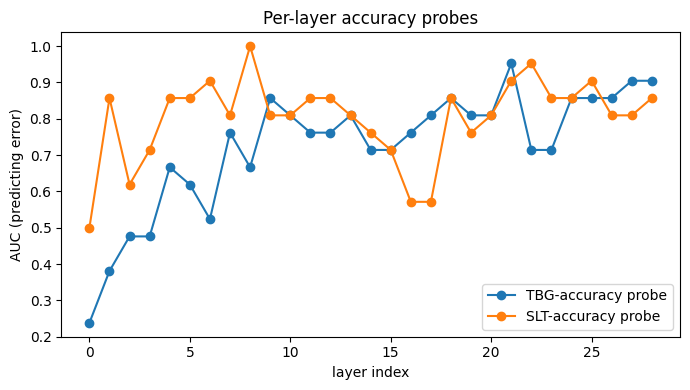

Best TBG accuracy layer 21: AUC = 0.952
Best SLT accuracy layer 8: AUC = 1.000


In [75]:
plt.figure(figsize=(7,4))
plt.plot(layers, ta_aucs, marker="o", label="TBG-accuracy probe")
plt.plot(layers, sa_aucs, marker="o", label="SLT-accuracy probe")
plt.xlabel("layer index")
plt.ylabel("AUC (predicting error)")
plt.title("Per-layer accuracy probes")
plt.legend()
plt.tight_layout()
plt.show()

best_tbg_acc_layer = int(np.nanargmax(ta_aucs))
best_slt_acc_layer = int(np.nanargmax(sa_aucs))
print(f"Best TBG accuracy layer {best_tbg_acc_layer}: AUC = {ta_aucs[best_tbg_acc_layer]:.3f}")
print(f"Best SLT accuracy layer {best_slt_acc_layer}: AUC = {sa_aucs[best_slt_acc_layer]:.3f}")


In [76]:
# sort indices by entropy
idx_sorted = np.argsort(entropy)

print("Lowest-entropy examples:")
for i in idx_sorted[:5]:
    ex = list(generations.values())[i]
    print(f"\n[{i}] entropy={entropy[i]:.3f}, acc={acc[i]:.0f}")
    print("Q:", ex["question"])
    print("Model:", ex["most_likely_answer"]["response"])

print("\nHighest-entropy examples:")
for i in idx_sorted[-5:]:
    ex = list(generations.values())[i]
    print(f"\n[{i}] entropy={entropy[i]:.3f}, acc={acc[i]:.0f}")
    print("Q:", ex["question"])
    print("Model:", ex["most_likely_answer"]["response"])


Lowest-entropy examples:

[0] entropy=-0.000, acc=1
Q: The International Bureau of Weights and Measures is based in which European country?
Model: The International Bureau of Weights and Measures is based in France.

[36] entropy=-0.000, acc=1
Q: What is the medical name for the breastbone?
Model: The medical name for the breastbone is the sternum.

[58] entropy=-0.000, acc=1
Q: The Erythraean Sea, lying between Africa and Asia is more commonly called the (What?) Sea?
Model: The Erythraean Sea, lying between Africa and Asia is more commonly called the (Red Sea) Sea.

[32] entropy=-0.000, acc=0
Q: Which country in 2001 became the first to decriminalize recreational drug use?
Model: The United States became the first country in the world to decriminalize recreational drug use in 2001.

[29] entropy=-0.000, acc=1
Q: What is the name for a natural satellite that orbits a planet?
Model: A natural satellite is a celestial body that orbits a planet. The name for a natural satellite is a moon.